<a href="https://colab.research.google.com/github/Mafaz03/Test-Checkpoints/blob/main/MIDaS_lidar_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 Importing Dependancies

In [1]:
import torch
import cv2 as cv
import matplotlib.pyplot as plt
import time
import numpy as np
from google.colab.patches import cv2_imshow

In [2]:
import os
from pathlib import Path
import requests
import zipfile

In [3]:
try:
  import timm
except:
  !pip install timm -q
  import timm

In [4]:
try:
  from torchinfo import summary
except:
  !pip install torchinfo -q
  from torchinfo import summary

#2 Setting device

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#3 Downloading model

In [6]:
model_type = "DPT_Large"
midas = torch.hub.load("intel-isl/MiDaS" , model_type)
midas.to(device)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

In [7]:
summary(midas)

Layer (type:depth-idx)                             Param #
DPTDepthModel                                      --
├─Module: 1-1                                      --
│    └─VisionTransformer: 2-1                      591,872
│    │    └─PatchEmbed: 3-1                        787,456
│    │    └─Dropout: 3-2                           --
│    │    └─Identity: 3-3                          --
│    │    └─Identity: 3-4                          --
│    │    └─Sequential: 3-5                        302,309,376
│    │    └─LayerNorm: 3-6                         2,048
│    │    └─Identity: 3-7                          --
│    │    └─Dropout: 3-8                           --
│    │    └─Linear: 3-9                            1,025,000
│    └─Sequential: 2-2                             --
│    │    └─ProjectReadout: 3-10                   2,098,176
│    │    └─Transpose: 3-11                        --
│    │    └─Unflatten: 3-12                        --
│    │    └─Conv2d: 3-13                 

#4 Setting transformers

In [8]:
midas_transforms = torch.hub.load("intel-isl/MiDaS" , "transforms")
transforms = midas_transforms.dpt_transform
transforms

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Compose(
    <function transforms.<locals>.<lambda> at 0x7f9b50621d80>
    <function transforms.<locals>.<lambda> at 0x7f9b50621e10>
)

#5 Importing Datasets

In [9]:
data_path = Path("data/")
image_path = data_path / "random_images"

image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "360_1.zip", "wb") as f:
  request = requests.get("https://github.com/Mafaz03/Datasets/raw/main/360/360-1.jpg.zip")
  f.write(request.content)

with zipfile.ZipFile(data_path / "360_1.zip", "r") as zip_ref:
  zip_ref.extractall(image_path)



In [20]:
three60_img = cv.imread("/content/data/random_images/360-1.jpg")
three60_img = cv.cvtColor(three60_img, cv.COLOR_BGR2RGB)
size = three60_img.shape[:2]

size_factor = 2

cv.resize(three60_img , (int(size[1]/size_factor) , int(size[0]/size_factor)))

array([[[212, 215, 220],
        [212, 215, 220],
        [212, 215, 220],
        ...,
        [213, 216, 223],
        [213, 216, 223],
        [212, 215, 222]],

       [[212, 215, 220],
        [212, 215, 220],
        [213, 216, 221],
        ...,
        [213, 216, 223],
        [212, 215, 222],
        [212, 215, 222]],

       [[212, 215, 222],
        [213, 216, 223],
        [212, 215, 222],
        ...,
        [213, 216, 223],
        [212, 215, 222],
        [212, 215, 222]],

       ...,

       [[141, 138, 131],
        [143, 140, 133],
        [140, 137, 131],
        ...,
        [141, 136, 132],
        [143, 138, 134],
        [144, 139, 135]],

       [[139, 136, 129],
        [140, 137, 130],
        [138, 135, 130],
        ...,
        [136, 131, 127],
        [140, 135, 131],
        [143, 138, 134]],

       [[139, 136, 129],
        [140, 137, 130],
        [141, 138, 133],
        ...,
        [142, 137, 133],
        [144, 139, 135],
        [142, 137, 133]]

(-0.5, 9931.5, 2074.5, -0.5)

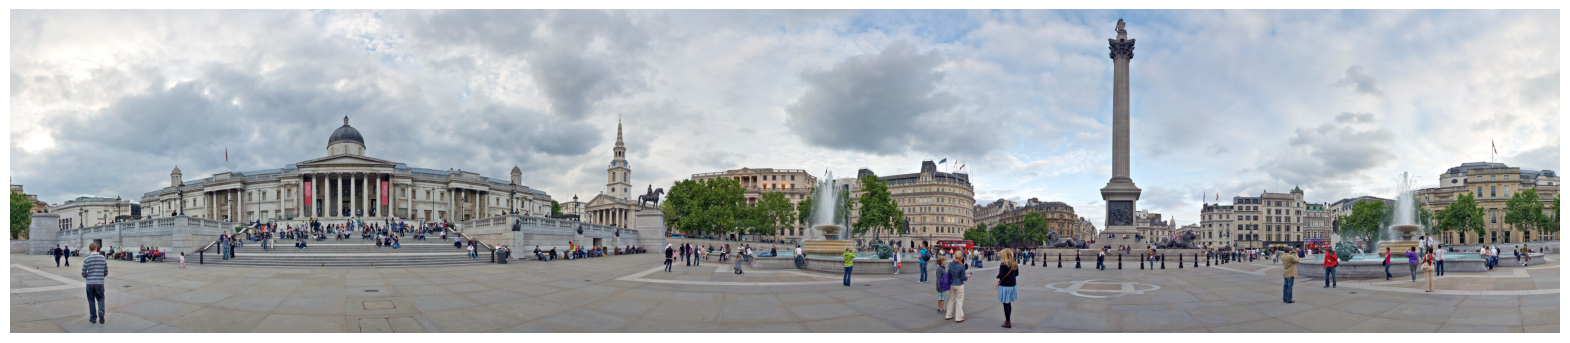

In [21]:
plt.figure(figsize = (20,20))
plt.imshow(three60_img)
plt.axis("off")

In [22]:
input_transformed = transforms(three60_img).to(device)
input_transformed.shape

torch.Size([1, 3, 384, 1824])

#6 Predicting

In [23]:
with torch.no_grad():
  prediction = midas(input_transformed)

  prediction = torch.nn.functional.interpolate(
      prediction.unsqueeze(1),
      size = three60_img.shape[:2],
      mode="bicubic",
      align_corners=False,
  ).squeeze()

  depth_map = prediction.cpu().numpy()
  depth_map = cv.normalize(depth_map , None , 0 , 1 , norm_type = cv.NORM_MINMAX , dtype = cv.CV_64F)

  depth_map = (depth_map*255).astype(np.uint8)
  depth_map = cv.applyColorMap(depth_map , cv.COLORMAP_MAGMA)

#7 Visualizing

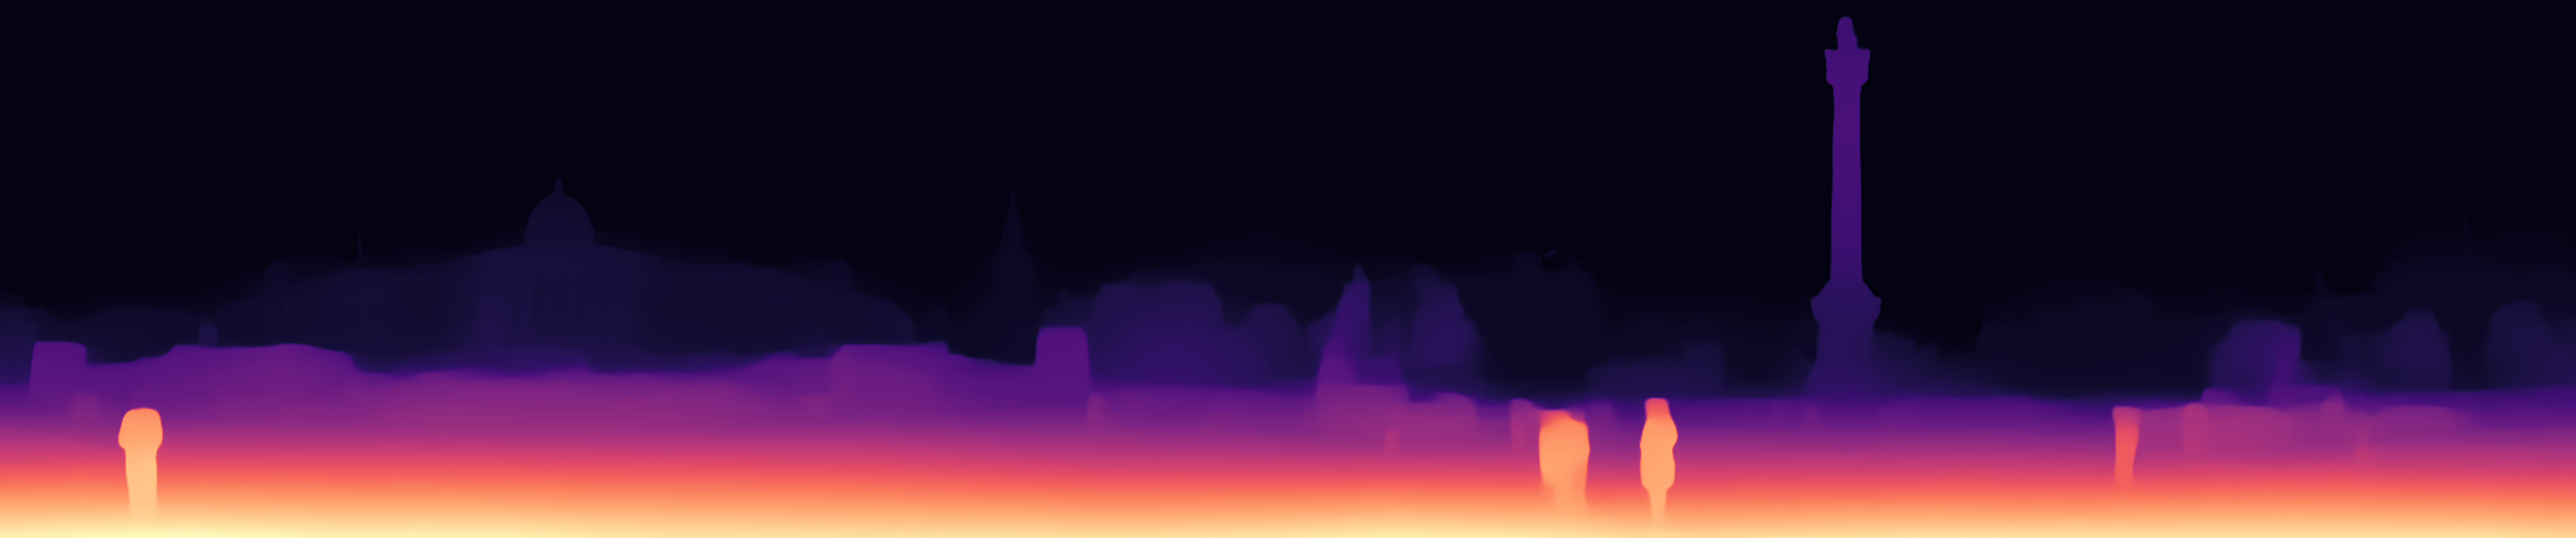

In [24]:
cv2_imshow(depth_map)

In [27]:
size = three60_img.shape[:2]
size

(2075, 9932)

(-0.5, 9831.5, 2024.5, -0.5)

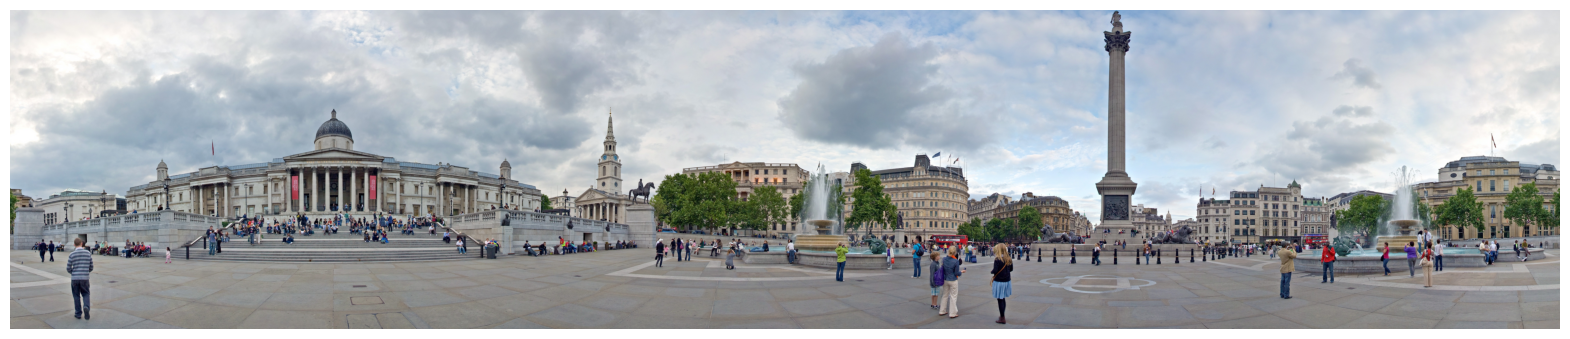

In [122]:
plt.figure(figsize = (20,20))
three60_img_squeezed = three60_img[50 : size[0] ,  100: size[1] ]
plt.imshow(three60_img_squeezed)
plt.axis("off")

(500, 7857, 3)


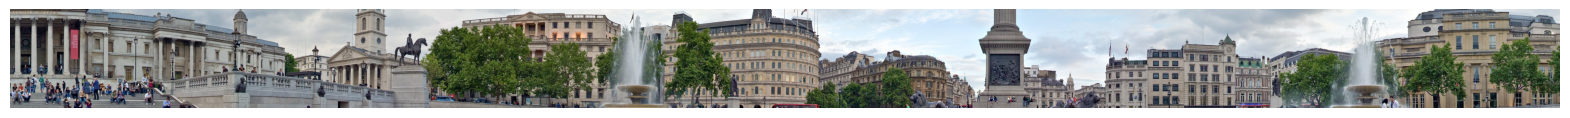

In [164]:
plt.figure(figsize = (20,20))
three60_img_squeezed = three60_img[ 1000 : 1500 ,  size[0] : size[1] ]
plt.imshow(three60_img_squeezed)
plt.axis("off")
print(three60_img_squeezed.shape)

In [165]:
input_transformed_squeezed = transforms(three60_img_squeezed).to(device)
input_transformed_squeezed.shape

torch.Size([1, 3, 384, 6048])

In [166]:
three60_img_squeezed.shape[:2]

(500, 7857)

In [178]:
with torch.no_grad():
  prediction = midas(input_transformed)

  prediction = torch.nn.functional.interpolate(
      prediction.unsqueeze(1),
      size = three60_img.shape[:2],
      mode="bicubic",
      align_corners=False,
  ).squeeze()

  prediction_squeezed = prediction[ 1000 : 1500 ,  size[0] : size[1] ]

  depth_map_squeezed = prediction_squeezed.cpu().numpy()
  depth_map_data = depth_map_squeezed
  depth_map_squeezed = cv.normalize(depth_map_squeezed , None , 0 , 1 , norm_type = cv.NORM_MINMAX , dtype = cv.CV_64F)

  depth_map_squeezed = (depth_map_squeezed*255).astype(np.uint8)
  depth_map_squeezed = cv.applyColorMap(depth_map_squeezed , cv.COLORMAP_MAGMA)

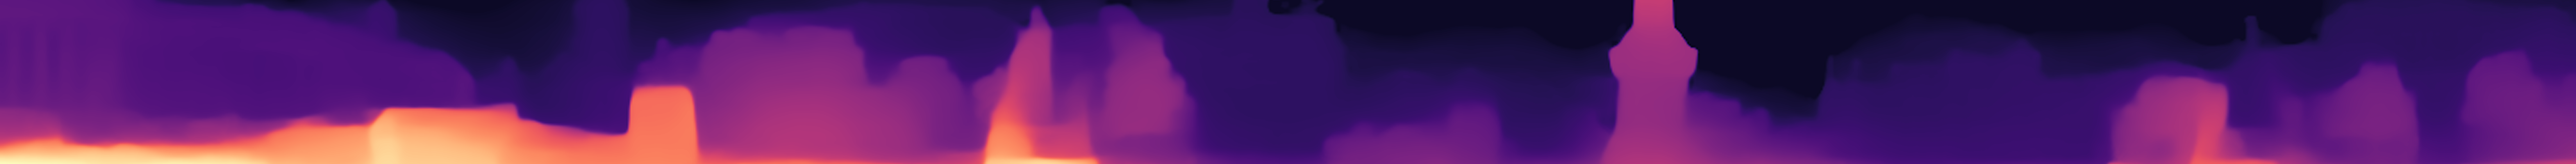

In [179]:
cv2_imshow(depth_map_squeezed)

In [175]:
prediction.shape

torch.Size([2075, 9932])

In [143]:
depth_map_squeezed = depth_map_data[ 1000 : 1500 ,  size[0] : size[1] ]

In [139]:
depth_map_squeezed.shape

(500, 7857)

In [ ]:
depth_map_data_norm = cv.normalize(depth_map_squeezed , None , 0 , 1 , norm_type = cv.NORM_MINMAX , dtype = cv.CV_64F)
depth_map_data_norm

In [153]:
depth_map_squeezed = (depth_map_data_norm*255).astype(np.uint8)
depth_map_squeezed = cv.applyColorMap(depth_map[ 1000 : 1500 ,  size[0] : size[1] ] , cv.COLORMAP_MAGMA)

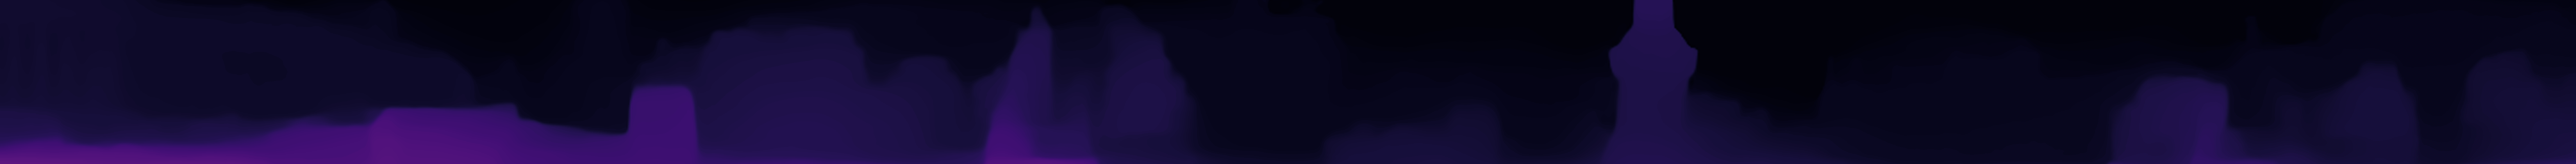

In [154]:
cv2_imshow(depth_map_squeezed)